# Double Exponential Jump Diffusion (DEJD) Validation Report

#### Report Date : 22 May 2023

### <u>Squad Members</u>
| Area | Person In Charge | 
| :- | :- | 
| Squad Leader | Magdalena (magdalena.nitefor@deriv.com) | 
| Project Manager | Maria Semashko (maria.semashko@deriv.com) | 
| Product Owner | Antoine Mille (antoine.mille@deriv.com) <br> Alassane (alassane@deriv.com) | 
| Backend | Afshin Paydar (afshin.paydar@deriv.com) | 
| Model Validation | Kuan Lim (kuanlim@deriv.com)|



## Product Information

### <u>Product Description</u>
Product Specification : https://docs.google.com/document/d/1aYXK3aZ6B-3d5jDWAhqvO60UAigiXHJE/edit

Perl Code (29 March 2023): https://github.com/regentmarkets/perl-Feed-Index-JumpDiffusion/tree/108c50f135b866e6972357c348949778a42dd743

A Double Exponential Jump Diffusion process simulates the financial markets with constant volatilities and can make large jumps. It is composed of geometric brownian motion to which we add Symmetric or Asymmetric jumps with Exponentially distributed sizes.

The index is generated every second.

The Jump index mimics a typical market where shocks can occur from news events. For example, the spot jumping downwards represents a bad news event, while a jump upwards represents a shock from a good news event.
Moreover, this model allows us to easily create indices that have an asymmetry between the positive and negative jumps (e.g. more positive jumps but small jump size and less negative jumps but big jump size)). 

There will be two asymmetic indices :
* DEX D900
* DEX U900

### <u>Construction</u>

The spot price at time t is defined based on the spot price the timestep before following :

$$
S_t=S_{t-1}exp\left[(r-d-\frac{\sigma^2}{2}-\lambda\alpha)dt+\sigma\sqrt{dt}W+\sum^{N(\lambda dt)}_{i=1}{J_i}\right]
$$

where

$$\begin{align*}
S&=\text{Spot Price}\\
r&=\text{Interest Rate}\\
d&=\text{Dividend Rate}\\
\sigma&=\text{Volatility}\\
N&=\text{Poisson Process with constant mean }\lambda dt\\
\lambda&=\text{Poisson Process mean}\\
dt&=\frac{1}{365*86400}\\
J&=\text{Random jump size from double expontial jump distribution }w\\
\alpha&=E(e^J-1)\\
W&=\text{Random number sample from normal distribution }
\end{align*}$$

The jump size $J$ follows double exponential jump distribution $w$:

$$
w(J)=\frac{q_{-}}{\eta_{-}}e^{\frac{J}{\eta_{-}}}1_{(J<0)}+\frac{q_{+}}{\eta_{+}}e^{-\frac{J}{\eta_{+}}}1_{(J\ge0)}
$$

where

$$\begin{align*}
q_{+}(q_{-})&=\text{Probability of positive/negative jump}\\
\eta_{+}(\eta_{-})&=\text{Expected size of positive(negative) jump}
\end{align*}$$

For DEX D900 and DEXU900, the parameters are:

|Index|Number of Jumps per Hour $\lambda$|Average Positive Jump Size $\eta_{+}$|Average Negative Jump Size $\eta_{-}$|Probability of Positive Jump $q_{+}$|Probability of Negative Jump $q_{-}$|Volatility|
|--|--|--|--|--|--|--|
|DEX U900|20, which is 175200 per year|0.30%|0.04%|20%|80%|25%|
|DEX D900|20, which is 175200 per year|0.04%|0.30%|80%|20%|25%|

## Model Validation

### Summary

For the validation of DEX indices, we cover the below areas and conclude the outcomes. More details can be found in respective section.

|Section|Area|Validation|Outcome|Passed?|
|-|-|-|-|-|
|1|$\alpha = E(e^J-1)$ derivation and computation| <li>  To check derivation of the drift adjustment for the jump process, namely $\alpha$ <li> To check the $\alpha$ is computed correctly, which involves the Moment Generating Function of the Double Exponential Jump Distribution | The formula in Perl are correct. |<b>Passed</b>|
|2|For the Double Jump Exponetial Jump process, the implementation is different from the specification.|In Perl code, firstly a random number from Uniform Distribution is generated. If the random number is below the probability of positive jump, the system will generate another random number from the exponential distribution with $\lambda = -\frac{1}{\eta_{+}}$, otherwise $\lambda = \frac{1}{\eta_{-}}$. This is different from the specification which does not mention there will be 2 random numbers.|Upon running the simulation based on these 2 methods, the moments are matching. |<b>Passed</b>|
|3|Check the moment of the feed data|We compute the moment of the feed data, and check whether it is matching with the true distribution.|We checked the moments of the feed data vs simulation. The moments are matching. |<b>Passed</b>|
|4|Backward engineering the parameters.| Here we check the parameters backward engineering from the feed data moment. We do not proceed with the MLE method as the implementation is very difficult to implement| The result looks fine with the set initial condition and boundary condition.|<b>Passed</b>|
|5|Convergence of the feed data moment| The convergence speed of the first 3 moments are checked.| It takes about 4 days to converge to the true moments. The result is fine.|<b>Passed</b>|



### Section 1

The derivation of the drift adjustment for the jump process is correct, which is $\alpha = E(e^J-1)$. The detailed derivation is in Appendix.

Also, the formula involves the moment generating function of the double exponential jump distribution, the derivation is also in Appendix. 

The formula is correct in perl, hence the validation is passed.



In [31]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import norm,skew,kurtosis,poisson
from scipy.optimize import minimize,fsolve
from IPython.display import display_html
from itertools import chain,cycle
from numba import njit,jit
from math import factorial


os.chdir("/Users/kuanlim/Documents/24. DEX Validation")

### Section 2

In here we use two methods to check the jump distribution without the diffusion part.

1) With 2 random numbers, which same as perl code.
2) With only 1 random number, the formula is shown in Appendix.


Running a simulation (DEX U900) based on these 2 methods, the moments (Mean, Volatility, Skewness and Kurtosis) are matching.


In [32]:
def mgf_jump(q,eta_p,eta_n,t=0):
    return q/(1-t*eta_p)+(1-q)/(1+t*eta_n)

def inv_J_cdf_mv(cdf,q,eta_p,eta_n):
    if cdf<1-q:
        return eta_n*np.log(cdf/(1-q))
    else:
        return -eta_p*np.log((1-cdf)/(q))
    

def inv_J_cdf_perl(cdf,q,eta_p,eta_n):
    n = np.random.uniform()
    if cdf<q:
        return -(eta_p*np.log(1-n))
        
    # Negative jump
    else:
        return eta_n*np.log(1-n)
    
def DEX_sim_jump_only(index,cdf,n=1000000):

    dt = 1/365/86400
    mu = 0
    vol = 0.25
    decay = 175200

    if index == 'DEX U900':
        eta_p = 0.04/100
        eta_n = 0.30/100
        q = 0.8
    elif index == 'DEX D900':
        eta_p = 0.30/100
        eta_n = 0.04/100
        q = 0.2

    a=mgf_jump(q,eta_p,eta_n,t=1)-1

    rand = np.random.uniform(size=n)
    return [cdf(x,q,eta_p,eta_n) for x in rand]
n=10000000
jump_perl=DEX_sim_jump_only("DEX U900",cdf=inv_J_cdf_perl,n=n)
jump_mv=DEX_sim_jump_only("DEX U900",cdf=inv_J_cdf_mv,n=n)

In [33]:
sim_compare = pd.DataFrame(index=['Mean','Volatility','Skewness','Kurtosis'],columns = ['Simulation based on Perl','Simulation based on MV logic','Difference %'])
sim_compare.loc['Mean','Simulation based on Perl'] =  np.mean(jump_perl)
sim_compare.loc['Volatility','Simulation based on Perl'] =  np.std(jump_perl)
sim_compare.loc['Skewness','Simulation based on Perl'] =  skew(jump_perl)
sim_compare.loc['Kurtosis','Simulation based on Perl'] =  kurtosis(jump_perl)

sim_compare.loc['Mean','Simulation based on MV logic'] =  np.mean(jump_mv)
sim_compare.loc['Volatility','Simulation based on MV logic'] =  np.std(jump_mv)
sim_compare.loc['Skewness','Simulation based on MV logic'] =  skew(jump_mv)
sim_compare.loc['Kurtosis','Simulation based on MV logic'] =  kurtosis(jump_mv)

sim_compare['Difference %'] = sim_compare['Simulation based on Perl'] /sim_compare['Simulation based on MV logic'] -1
sim_compare

,Simulation based on Perl,Simulation based on MV logic,Difference %
Mean,-0.00028,-0.00028,-0.000984
Volatility,0.001944,0.001944,0.000391
Skewness,-3.939029,-3.937295,0.00044
Kurtosis,21.933217,21.917746,0.000706


### Section 3

In here we are checking the moments of the real feed data. The Validation Steps are:
1) Obtain the feed data from MT5 demo accounts. 
2) Compute the feed data moments (Mean, Volatility, Skewness & Kurtosis).
3) Run the simulation and compute the moments.
4) Compare (2) & (3)

Conclusion:
1) Mean - Acceptable as the abs difference is low.
2) Volatility - Acceptable as both abs and rel difference are low.
3) Skewness - Acceptable as rel difference is low.
4) Kurtosis - Acceptable.

In [34]:
def data_massage(df):
    df.columns = [s.replace("<","").replace(">","") for s in df.columns]
    df['ts'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
    df.sort_values('ts',inplace=True)
    df['mid'] = (df.BID + df.ASK)/2
    df['return'] = np.log(df['mid']/df['mid'].shift(1))
    df['moment_1'] = (dex_u['mid']/dex_u['mid'].shift(1))**2
    df['moment_2'] = (dex_u['mid']/dex_u['mid'].shift(1))**2
    df['moment_3'] = (dex_u['mid']/dex_u['mid'].shift(1))**3
    df['moment_4'] = (dex_u['mid']/dex_u['mid'].shift(1))**4
    df['moment_5'] = (dex_u['mid']/dex_u['mid'].shift(1))**5
    df['moment_6'] = (dex_u['mid']/dex_u['mid'].shift(1))**6

    df['spread_perct'] = (df.ASK-df.BID)/ df['mid']

    df = df.tail(-1)

    return df

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:top"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: top;"><font size="-1">{title}</font></h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

dex_u = pd.read_csv("DEX 900 UP Index_202304190750_202304260622.csv",sep=r"\t",engine="python")
dex_d = pd.read_csv("DEX 900 DOWN Index_202304190750_202304260622.csv",sep=r"\t",engine="python")
dex_u  = data_massage(dex_u)
dex_d  = data_massage(dex_d)


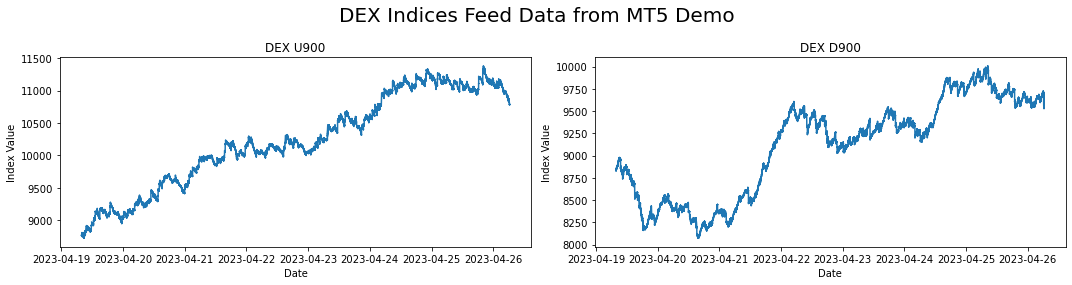

In [35]:
fig, ax = plt.subplots(ncols=2,figsize=(15,4))
ax[0].plot(dex_u['ts'],dex_u['mid'])
ax[1].plot(dex_d['ts'],dex_d['mid'])
# Set x- and y-axis labels for each subplot|
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Index Value')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Index Value')

ax[0].set_title('DEX U900')
ax[1].set_title('DEX D900')

plt.suptitle('DEX Indices Feed Data from MT5 Demo',fontsize=20)

plt.tight_layout()

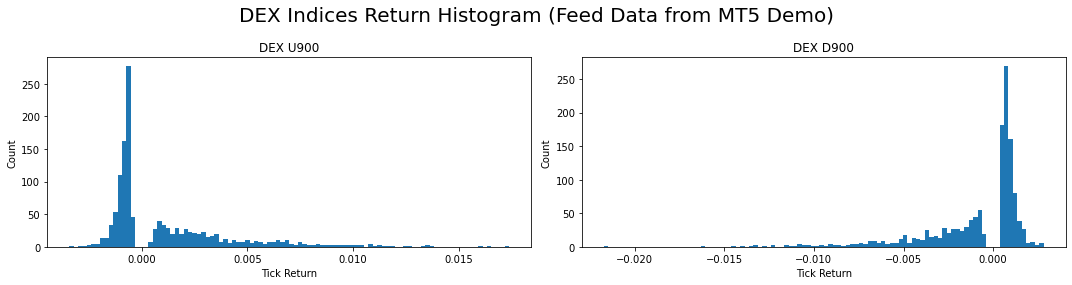

In [36]:
fig, ax = plt.subplots(ncols=2,figsize=(15,4))
ax[0].hist(dex_u[abs(dex_u['return'])>0.0005]['return'],bins=100);
ax[1].hist(dex_d[abs(dex_d['return'])>0.0005]['return'],bins=100);

# Set x- and y-axis labels for each subplot|
ax[0].set_xlabel('Tick Return')
ax[0].set_ylabel('Count')
ax[1].set_xlabel('Tick Return')
ax[1].set_ylabel('Count')

ax[0].set_title('DEX U900')
ax[1].set_title('DEX D900')

plt.suptitle('DEX Indices Return Histogram (Feed Data from MT5 Demo)',fontsize=20)

plt.tight_layout()

In [37]:
def DEX_sim(index,cdf,n=1000000):
    np.random.seed(1)
    S0 = 100
    dt = 1/365/86400
    mu = 0
    vol = 0.25
    decay = 175200

    if index == 'DEX U900':
        eta_p = 0.30/100
        eta_n = 0.04/100
        q = 0.2
    elif index == 'DEX D900':
        eta_p = 0.04/100
        eta_n = 0.30/100
        q = 0.8

    a=mgf_jump(q,eta_p,eta_n,t=1)-1
    
    S=np.zeros(n+1)
    W = np.random.normal(size=n)
    N = np.random.poisson(decay*dt,size=n)
    S[0] = 1
    S[1:]=np.exp((mu-vol**2/2-decay*a)*dt+vol*np.sqrt(dt)*W)

    for i in range(n):
        if N[i]>0:
            for j in range(N[i]):
                J = cdf(np.random.uniform(),q,eta_p,eta_n)
                S[i+1]*=np.exp(J)    

    S=S.cumprod()
    return S*S0

n=3000000
S_up_mv=DEX_sim("DEX U900",cdf=inv_J_cdf_mv,n=n)
S_down_mv=DEX_sim("DEX D900",cdf=inv_J_cdf_mv,n=n)

r_up_mv = np.log(S_up_mv[1:]/S_up_mv[:-1])
r_down_mv = np.log(S_down_mv[1:]/S_down_mv[:-1])

In [38]:
# Calculating Moment from Empirical Data
def emp_moment(index,df,df_moment):
    df_moment.loc[index,'Mean'] = df['return'].mean()
    df_moment.loc[index,'Volatility'] = df['return'].std()
    df_moment.loc[index,'Skewness'] = df['return'].skew()
    df_moment.loc[index,'Kurtosis'] = df['return'].kurt()
    return df_moment

# Calculating Moment from Simulation Data
def true_moment(df,r_up_mv,r_down_mv):

    index = 'DEX U900'
    df.loc[index,'Mean'] = np.mean(r_up_mv)
    df.loc[index,'Volatility'] = np.std(r_up_mv)
    df.loc[index,'Skewness'] = skew(r_up_mv)
    df.loc[index,'Kurtosis'] = kurtosis(r_up_mv)

    index = 'DEX D900'
    df.loc[index,'Mean'] = np.mean(r_down_mv)
    df.loc[index,'Volatility'] = np.std(r_down_mv)
    df.loc[index,'Skewness'] = skew(r_down_mv)
    df.loc[index,'Kurtosis'] = kurtosis(r_down_mv)

    return df

df_feed = pd.DataFrame(index=['DEX U900','DEX D900'],columns = ['Mean','Volatility','Skewness','Kurtosis'])
df_feed = emp_moment('DEX U900',dex_u,df_feed)
df_feed = emp_moment('DEX D900',dex_d,df_feed)

df_true = pd.DataFrame(index=['DEX U900','DEX D900'],columns = ['Mean','Volatility','Skewness','Kurtosis'])
df_true = true_moment(df_true,r_up_mv,r_down_mv)


df_diff_abs = df_feed-df_true
df_diff_rel = df_feed/df_true -1

pd.set_option("display.precision", 8)
display_side_by_side(df_feed,df_true,df_diff_abs,df_diff_rel,titles=['Feed Data Moments','Simulation Moments','Difference (abs)','Difference (rel)'])

,Mean,Volatility,Skewness,Kurtosis
DEX U900,0.00000034,0.00015455,45.20972819,2953.52457144
DEX D900,0.00000013,0.00014861,-47.67062871,3541.44072733
,Mean,Volatility,Skewness,Kurtosis
DEX U900,-0.00000001,0.00015233,50.47877365,4086.6369544
DEX D900,0.00000006,0.00015115,-48.81241142,3631.46821956
,Mean,Volatility,Skewness,Kurtosis
DEX U900,0.00000035,0.00000221,-5.26904546,-1133.11238295
DEX D900,0.00000007,-0.00000254,1.14178271,-90.02749223
,Mean,Volatility,Skewness,Kurtosis
DEX U900,-34.82185545,0.01453387,-0.10438141,-0.27727258


### Section 4

Here we check the parameters backward engineering from the feed data moments.

The result is highly dependable on the initial and boundary condition. The difference in the results are acceptable.

In [39]:
# def eq_moment(params,n):
#     dt=1/365/86400
#     vol = params[0]
#     lam = params[1]/dt
#     q = params[2]
#     eta_p = params[3]
#     eta_n = params[4]
#     a = mgf_jump(q,eta_p,eta_n,t=1)-1
#     result= np.exp(-0.5*vol**2*n*dt)
#     result= np.exp(-n*lam*a*dt)
#     result*= np.exp(0.5*(n*vol)**2*dt)
#     result*= np.exp(lam*dt*(mgf_jump(q,eta_p,eta_n,t=n)-1))

#     return result

def eq_moment(params,n):
    dt=1/365/86400
    vol = params[0]
    lam = params[1]
    q = params[2]
    eta_p = params[3]
    eta_n = params[4]
    a = mgf_jump(q,eta_p,eta_n,t=1)-1

    p=1-q

    if n==1:
        result = -0.5*vol**2*dt-lam*dt*a + lam*dt*(q*eta_p-p*eta_n)
    elif n==2:
        result = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
    else:
        variance = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
        result = lam*dt*factorial(n)*((-1)**(n)*p*eta_n**(n)+q*eta_p**(n))/(variance**(n/2))
    return result

def func(params,moments):
    eq =[eq_moment(params,1) - moments[0], eq_moment(params,2) - moments[1], eq_moment(params,3) - moments[2], eq_moment(params,4) - moments[3], eq_moment(params,5) - moments[4]]
    result = np.sum(np.power(eq,2))
    return result

def params_solve(index,df):
    # Get the target
    moment_1 = np.mean(df['return']**1)
    moment_2 = np.mean((df['return']-moment_1)**2)
    moment_3 = np.mean((df['return']-moment_1)**3)/moment_2**(3/2)
    moment_4 = np.mean((df['return']-moment_1)**4)/moment_2**(4/2)
    moment_5 = np.mean((df['return']-moment_1)**5)/moment_2**(5/2)
    moment_6 = np.mean((df['return']-moment_1)**6)/moment_2**(6/2)

    moments = [moment_1,moment_2,moment_3,moment_4,moment_5,moment_6]
    # Solve for the unknown parameters
    if index == 'DEX U900':
        params_guess = [0.25,175200,0.20,0.30/100,0.04/100]
    else:
        params_guess = [0.25,175200,0.80,0.04/100,0.30/100]
    
    params_guess = np.multiply(params_guess,0.99)

    bound = 0.03
    bounds = []
    for params in params_guess:
        bounds.append((params*(1-bound),params*(1+bound)))

    result = minimize(func,params_guess,bounds=bounds,args=(moments))
    params_solve = result.x
    return params_solve


df_params_feed = pd.DataFrame(index=['DEX U900','DEX D900'],columns = ['Vol','Lambda','Probability','Positive Eta','Negative Eta'])

dex_u_params = params_solve('DEX U900',dex_u)
df_params_feed.loc['DEX U900','Vol'] = dex_u_params[0]
df_params_feed.loc['DEX U900','Lambda'] = dex_u_params[1]
df_params_feed.loc['DEX U900','Probability'] = dex_u_params[2]
df_params_feed.loc['DEX U900','Positive Eta'] = dex_u_params[3]
df_params_feed.loc['DEX U900','Negative Eta'] = dex_u_params[4]

dex_d_params = params_solve('DEX D900',dex_d)
df_params_feed.loc['DEX D900','Vol'] = dex_d_params[0]
df_params_feed.loc['DEX D900','Lambda'] = dex_d_params[1]
df_params_feed.loc['DEX D900','Probability'] = dex_d_params[2]
df_params_feed.loc['DEX D900','Positive Eta'] = dex_d_params[3]
df_params_feed.loc['DEX D900','Negative Eta'] = dex_d_params[4]

df_params_true = pd.DataFrame(index=['DEX U900','DEX D900'],columns = ['Vol','Lambda','Probability','Positive Eta','Negative Eta'])

df_params_true.loc['DEX U900','Vol'] = 0.25
df_params_true.loc['DEX U900','Lambda'] = 175200
df_params_true.loc['DEX U900','Probability'] = 0.2
df_params_true.loc['DEX U900','Positive Eta'] = 0.3/100
df_params_true.loc['DEX U900','Negative Eta'] = 0.04/100

df_params_true.loc['DEX D900','Vol'] = 0.25
df_params_true.loc['DEX D900','Lambda'] = 175200
df_params_true.loc['DEX D900','Probability'] = 0.8
df_params_true.loc['DEX D900','Positive Eta'] = 0.04/100
df_params_true.loc['DEX D900','Negative Eta'] =  0.3/100

df_params_diff = df_params_feed/df_params_true-1

pd.set_option("display.precision", 8)
display_side_by_side(df_params_feed,df_params_true,df_params_diff,titles=['Feed Data Params','True Params','Difference (rel)'])

,Vol,Lambda,Probability,Positive Eta,Negative Eta
DEX U900,0.254925,178651.44,0.20394,0.0028809,0.00040788
DEX D900,0.24166751,177918.00146253,0.76824,0.00040788,0.0028809
,Vol,Lambda,Probability,Positive Eta,Negative Eta
DEX U900,0.25,175200,0.2,0.003,0.0004
DEX D900,0.25,175200,0.8,0.0004,0.003
,Vol,Lambda,Probability,Positive Eta,Negative Eta
DEX U900,0.0197,0.0197,0.0197,-0.0397,0.0197
DEX D900,-0.03332998,0.01551371,-0.0397,0.0197,-0.0397


### Section 5

We want to check the convergence speed of the DEX feed data in term of the moments.

Overall looks fine.

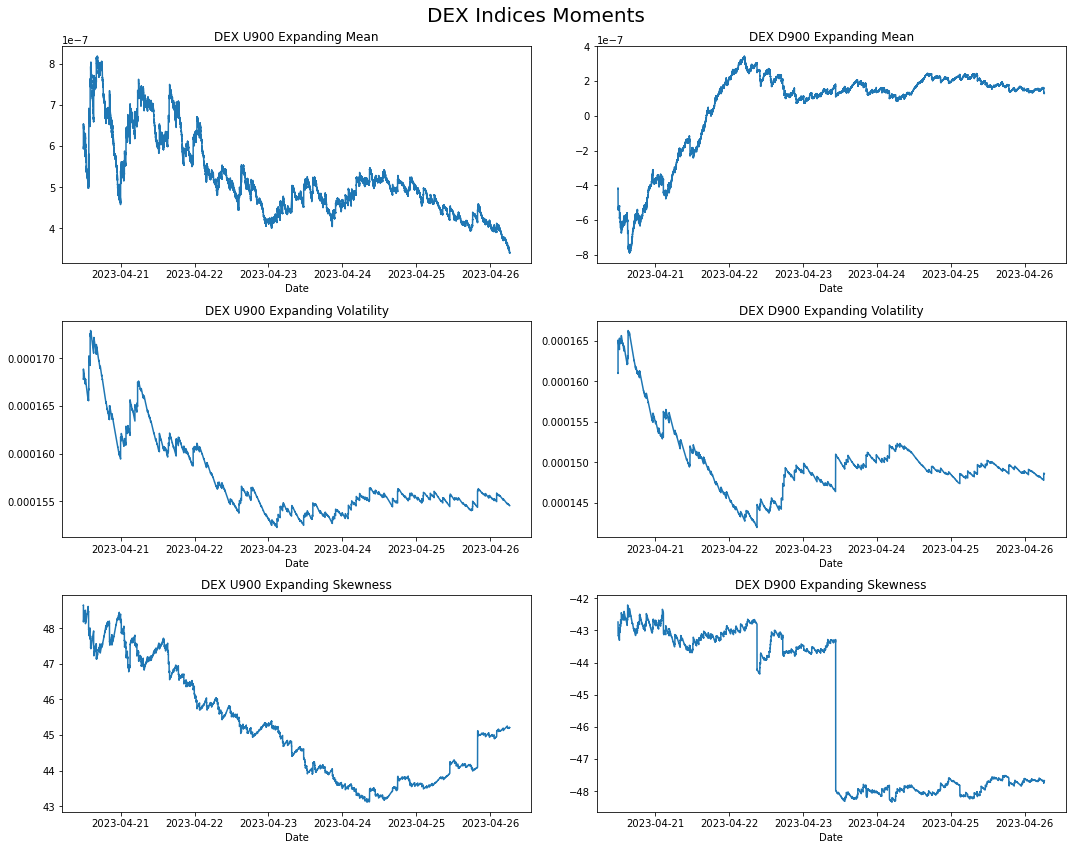

In [40]:
dex_u['expanding_mean'] =dex_u['return'].expanding(100000).mean()
dex_u['expanding_vol'] =dex_u['return'].expanding(100000).std()
dex_u['expanding_skew'] =dex_u['return'].expanding(100000).skew()

dex_d['expanding_mean'] =dex_d['return'].expanding(100000).mean()
dex_d['expanding_vol'] =dex_d['return'].expanding(100000).std()
dex_d['expanding_skew'] =dex_d['return'].expanding(100000).skew()


fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(15,12))

ax[0,0].plot(dex_u['ts'],dex_u['expanding_mean'])
ax[1,0].plot(dex_u['ts'],dex_u['expanding_vol'])
ax[2,0].plot(dex_u['ts'],dex_u['expanding_skew'])

ax[0,1].plot(dex_d['ts'],dex_d['expanding_mean'])
ax[1,1].plot(dex_d['ts'],dex_d['expanding_vol'])
ax[2,1].plot(dex_d['ts'],dex_d['expanding_skew'])

for i in range(3):
    for j in range(2):
        ax[i,j].set_xlabel('Date')

ax[0,0].set_title('DEX U900 Expanding Mean')
ax[1,0].set_title('DEX U900 Expanding Volatility')
ax[2,0].set_title('DEX U900 Expanding Skewness')

ax[0,1].set_title('DEX D900 Expanding Mean')
ax[1,1].set_title('DEX D900 Expanding Volatility')
ax[2,1].set_title('DEX D900 Expanding Skewness')

plt.suptitle("DEX Indices Moments", fontsize=20)
plt.tight_layout()


In [ ]:

# MLE method to backward engineering the parameters is extremely difficult
# We find another way to retrieve the parameters. 


# # # example
# # def neg_llh(popt, X):
# #     return np.log(norm.pdf(X, loc = popt[0], scale = popt[1])).sum()

# # # example data
# # X = np.random.normal(loc = 5, scale = 2, size = 1000000)

# # # minimize log likelihood
# # res = minimize(neg_llh, x0 = [2, 2], args = (X))

# # # print(res.x)

# def pdf_mix(r,X):
    
#     pdf=0
#     dt = 1/365/86400
#     vol=X[0]
#     decay=X[1]
#     q=X[2]
#     eta_p=X[3]
#     eta_n=X[3]

#     a=mgf_jump(q,eta_p,eta_n,t=1)-1

#     drift = (-vol**2/2-decay*a)*dt
#     sigma = vol *np.sqrt(dt)

#     normal_jump_p = np.exp(1/eta_p*(drift+r)+0.5*sigma**2*(1/eta_p)**2)-1
#     normal_jump_n = np.exp(-1/eta_n*(drift+r)+0.5*sigma**2*(1/eta_n)**2)-1

#     # i=0
#     pdf += poisson.pmf(0,mu=decay*dt)*norm.pdf(r,loc=drift,scale=vol)

#     # i=1
#     pdf += poisson.pmf(1,mu=decay*dt)*((1-q)*normal_jump_n+q*normal_jump_p)

#     return pdf

# def neg_llh(pop, X):
#     return -np.log([pdf_mix(r,X) for r in X]).sum()


# # minimize negative log likelihood
# dt = 1/365/86400
# # mu = 0 
# vol = 0.25
# decay = 175200

# # if index == 'DEX U900':
# #     eta_p = 0.30/100
# #     eta_n = 0.04/100
# #     q = 0.2
# # elif index == 'DEX D900':
# #     eta_p = 0.04/100
# #     eta_n = 0.30/100
# #     q = 0.8

# x0=[0.20,175200,0.2,0.04/100,0.30/100]
# x0=[0.23,200200,0.21,0.03/100,0.40/100]

# r = np.array(dex_u['return'].dropna());
# res = minimize(neg_llh, x0 = x0, args = (r))


## Appendix

### Double Jump Drift Correction Derivation

We want to find the drift correction for $S = \sum_{i=1}^N J_i$ where $N \sim Poisson(\lambda dt)$ and $J_i$ is i.i.d. That is, we want to find $\alpha$ such that:

$$
S_t = S_{t-1}\exp\left[-\alpha\cdot \lambda dt + S\right]
$$

has zero drift, i.e:

$$
E\left[\frac{S_t}{S_{t-1}}\right] = E\left[e^{-\alpha\cdot \lambda dt + S}\right] =1
$$

So we condition over $N$

$$
E\left[e^S\right] = E\left[ E\left( e^{S} \mid N\right)\right]
$$

Since $N$ is fixed in this context, we can calculate $E\left( e^{S} \mid N\right)$:

$$
E\left( e^{S} \mid N\right) = E\left[\exp\left(\sum_{i=1}^N J_i\right)\right] = E\left[\prod_{i=1}^N e^{J_i}\right] = \prod_{i=1}^N E\left[e^{J_i}\right]
$$

By independence of the $J_i$. Since they are identically distributed, $E[e^{J_i}] = E[e^{J_1}]$, hence it is constant. We define the constant $\beta$ such that:

$$
e^\beta = E[e^{J_1}]
$$

Then:

$$
E\left[ E\left( e^{S} \mid N\right)\right] = E\left[\prod_{i=1}^N E\left[e^{J_i}\right]\right] = E\left[\prod_{i=1}^N E\left[e^{J_1}\right]\right] = E\left[\prod_{i=1}^N e^{\beta}\right] = E\left[(e^{\beta})^N\right]
$$

We may rewrite this using the moment-generating funtion for $N$:

$$
E\left[e^{\beta \cdot N}\right] = MGF_{N(\lambda dt)}(\beta) = \exp\left[\lambda dt (e^\beta - 1)\right]
$$

Finally:

$$
E\left[e^{-\alpha\cdot \lambda dt + S}\right] = e^{-\alpha\cdot \lambda dt + (e^\beta - 1)\lambda dt } = 1
$$

So 

$$
\alpha = e^\beta - 1 = E[e^J - 1]
$$



### Moment Generating Function of Jump Size J

Here show the computation:

$$\begin{align*}
E(e^{tJ})&=\int^{0}_{-\infty}\frac{q_{-}}{\eta_{-}}e^{tJ}e^{\frac{J}{\eta_{-}}} dJ+\int^{\infty}_{0}\frac{q_{+}}{\eta_{+}}e^{tJ}e^{-\frac{J}{\eta_{+}}} dJ\\
&=\int^{0}_{-\infty}\frac{q_{-}}{\eta_{-}}e^{\frac{(t\eta_{-}+1)J}{\eta_{-}}} dJ+\int^{\infty}_{0}\frac{q_{+}}{\eta_{+}}e^{-\frac{(1-t\eta_{+})J}{\eta_{+}}} dJ\\
&=\frac{q_{-}}{\eta_{-}}\times\frac{\eta_{-}}{t\eta_{-}+1}\times e^{\frac{(t\eta_{-}+1)J}{\eta_{-}}}\Big|_{-\infty}^0 + \frac{q_{+}}{\eta_{+}}\times\frac{\eta_{+}}{-(1-t\eta_{+})}\times e^{-\frac{(1-t\eta_{+})J}{\eta_{+}}}\Big|_0^{\infty}\\
&=\frac{q_{-}}{t\eta_{-}+1}-\frac{q_{+}}{-(1-t\eta_{+})}\\
&=\frac{q_{-}}{t\eta_{-}+1}+\frac{q_{+}}{(1-t\eta_{+})}
\end{align*}
$$


### Moments of Jump Size J

We can find the first moment using WolframAlpha:

$$
\frac{d}{dt} E[e^{tJ}] = - \frac{q_- \eta_-}{(1+\eta_- t)^2} + \frac{q_+ \eta_+}{(1-\eta_+ t)^2}
$$

And 

$$
E[X] = \left. \frac{d}{dt} E[e^{tJ}] \right|_{t=0} = - q_- \eta_- + q_+ \eta_+
$$

Furthermore

$$
E[J^2] = \left. \frac{d^2}{dt^2} E[e^{tJ}] \right|_{t=0} = \left. \frac{2q_-\eta_-^2}{(1+\eta_- t)^3} + \frac{2q_+\eta_+^2}{(1-\eta_+ t)^3} \right|_{t=0} = 2q_-\eta_-^2 + 2q_+\eta_+^2
$$

$$
E[J^3] = \left. \frac{d^3}{dt^3} E[e^{tJ}] \right|_{t=0} = \left. -\frac{6q_-\eta_-^3}{(1+\eta_- t)^4} + \frac{6q_+\eta_+^3}{(1-\eta_+ t)^4} \right|_{t=0} = -6q_-\eta_-^3 + 6q_+\eta_+^3
$$

$$
E[J^4] = \left. \frac{d^4}{dt^4} E[e^{tJ}] \right|_{t=0} = \left. \frac{24q_-\eta_-^4}{(1+\eta_- t)^5} + \frac{24q_+\eta_+^4}{(1-\eta_+ t)^5} \right|_{t=0} = 24q_-\eta_-^4 + 24q_+\eta_+^4
$$

In general:

$$
E[J^n] = n![(-1)^nq_- \eta_-^n + q_+ \eta_+^n]
$$

### Moments of $S$

Using the same principle as earlier, we can calculate the MGF of $S$:

$$
E[e^{tS}] = \exp\left[ \lambda dt (E[e^tJ] - 1) \right] = \exp\left[ \lambda dt ( \frac{q_-}{1+t\eta_-} + \frac{q_+}{1-t\eta_+} - 1) \right]
$$

The first & second moments (Noting that $q_- + q_+ = 1$):

$$\begin{align*}
E[S] &= \left. \frac{d}{dt} E[e^{tS}] \right|_{t=0} \\
&= \left. \lambda dt \left( - \frac{q_- \eta_-}{(1+\eta_- t)^2} + \frac{q_+ \eta_+}{(1-\eta_+ t)^2} \right)\exp\left[ \lambda dt ( \frac{q_-}{1+t\eta_-} + \frac{q_+}{1-t\eta_+} - 1) \right] \right|_{t=0} \\
&= \lambda dt (-q_- \eta_- + q_+ \eta_+) = \lambda dt E[J]
\end{align*}$$

$$\begin{aligned}
E[S^2] &= \left. \frac{d^2}{dt^2} E[e^{tS}] \right|_{t=0} \\
&=  \left[ \lambda^2 dt^2 \left( - \frac{q_- \eta_-}{(1+\eta_- t)^2} + \frac{q_+ \eta_+}{(1-\eta_+ t)^2} \right)^2 \right. \\ 
&\quad + \left. \left. \lambda dt \left( \frac{2q_-\eta_-^2}{(1+\eta_- t)^3} + \frac{2q_+\eta_+^2}{(1-\eta_+ t)^3} \right) \right] \exp\left[ \lambda dt ( \frac{q_-}{1+t\eta_-} + \frac{q_+}{1-t\eta_+} - 1) \right] \right|_{t=0} \\
&= \lambda^2 dt^2 \left( - q_- \eta_- + q_+ \eta_+ \right)^2 + \lambda dt \left( 2q_-\eta_-^2 + 2q_+\eta_+^2 \right)\\
&= E[S]^2 + \lambda dt E[J^2]
\end{aligned}$$

We can convert to central moments ($E[(x-E(X))^n]$) for the second, third and fourth moments:

$$
Var(S) = E[(S-E(S))^2] = E[S^2] - E[S]^2 = \lambda dt E[J^2]
$$

$$
E[(S-E(S))^3] = E[S^3] - 3E[S^2]E[S] + 2 E[S]^3 = \lambda dt E[J^3]
$$

In general:

$$
E[(S-E(S))^n] = \lambda dt E[J^n]
$$


### Inverse CDF of DEJD with Single Random Number

To derive the inverse cdf of the Double Exponential Jump distribution, firstly we generate the random number from a uniform distribution between 0 and 1.

If the random number is less than the probability of negative jump, i.e. $r<q_{-}$:

$$\begin{align*}
F(X)&=\int^{x}_{-\infty}\frac{q_{-}}{\eta_{-}}e^{\frac{J}{\eta_{-}}}dJ\\
r&=q_{-}e^{\frac{J}{\eta_{-}}}\big|^{x}_{-\infty}\\
r&=q_{-}e^{\frac{x}{\eta_{-}}}\\
\end{align*}$$

Then we will get:

$$x=\eta_{-}\times ln(\frac{r}{q_{-}})$$

If the random number is more the probability of negative jump, i.e. $r>q_{-}$:

$$\begin{align*}
F(X)&=\int^{\infty}_{0}\frac{q_{+}}{\eta_{+}}e^{-\frac{J}{\eta_{+}}} dJ + \int^{0}_{-\infty}\frac{q_{-}}{\eta_{-}}e^{\frac{J}{\eta_{-}}}dJ\\
r&=-q_{+}e^{-\frac{J}{\eta_{+}}}\big|^{x}_{0} + q_{-}\\
r&=-q_{+}e^{-\frac{x}{\eta_{+}}}+q_{+} + q_{-}\\
r&=-q_{+}e^{-\frac{x}{\eta_{+}}}+q_{+} + (1-q_{+})\\
r&=-q_{+}e^{-\frac{x}{\eta_{+}}}+1\\
\end{align*}$$

In result : 

$$x=-\eta_{+}\times ln(\frac{1-r}{q_{+}})$$

R&D effort needs to be in line with Deriv’s vision and mission as formulated by our CEO. Therefore all R&D projects are carefully selected by our C-Level senior management represented by JY and Rakshit and resources for the projects are only allocated after review and shortlisting based on their vision and priorities. 

In line with the standards and criterias set out by the CEO, the Model Validation team has validated the product/indices as documented in this report.